# 割引クーポンキャンペーンの効果最大化

## 1. 問題設定
予算とダイレクトメール送付率の制約条件のもとで来客数を最大化する問題を考える

#### 1-1. 前提条件  
 ‐ 予算は100万円
 - 雑貨店の会員数は5000人
 - 全会員に対して次の3種類のいずれかのパターンのダイレクトメールを送付する
   1. セールのチラシのみ
   2. セールのチラシと1000円のクーポン
   3. セールのチラシと2000円のクーポン
 - 継続的な施策実施のため、次回以降の割引クーポンキャンペーンで利用する来店率のデータを一定数取得するように、「来店傾向を基に会員をグルーピングしたセグメントごとに10％以上ずるダイレクトメールを送付する」という条件を付ける
 - クーポン付与による来客増加数を最大化したい
 - 会員情報として下記がある
   - 年齢区分
   - 昨年度の来店回数区分
 - 一部会員のアンケート結果を基に、年齢区分と昨年度来店回数区分の組で定義される会員のセグメントに対して、各パターンのダイレクトメールを受け取った際に来店する確率が推定される
 
#### 1-2. 解くべき最適化問題の要件
 - 要件１：各会員に対してどのパターンのダイレクトメールを送付するか決定
 - 要件２：送付するダイレクトメールはどれか1パターン
 - 要件３：来客増加数を最大化する
 - 要件４：会員の予算消費期待値の合計は100万円以下（予算オーバーを防ぐ）
 - 要件５：各パターンのダイレクトメールをそれぞれのセグメントに属する会員の10％以上に送付

## 2. 必要ライブラリのインポートとデータの理解

In [1]:
import numpy as np
import pandas as pd
import pulp
import seaborn as sns
import matplotlib.pyplot as plt

#### 2-1. 顧客情報

In [2]:
customer_df = pd.read_csv("./data/customers.csv")
customer_df

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [16]:
customer_df.describe(include= 'all' )

,customer_id,age_cat,freq_cat
count,5000.000000,5000,5000
unique,NaN,4,4
top,NaN,age35~49,freq0
freq,NaN,2000,2000
mean,2500.500000,NaN,NaN
std,1443.520003,NaN,NaN
min,1.000000,NaN,NaN
25%,1250.750000,NaN,NaN
50%,2500.500000,NaN,NaN
75%,3750.250000,NaN,NaN


In [3]:
customer_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

In [9]:
customer_df["age_cat"].unique()

array(['age20~34', 'age35~49', 'age~19', 'age50~'], dtype=object)

In [17]:
customer_df["freq_cat"].unique()

array(['freq2', 'freq0', 'freq1', 'freq3~'], dtype=object)

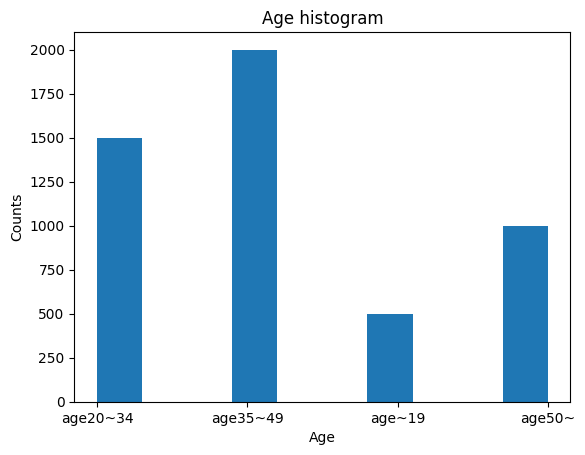

In [10]:
plt.hist(customer_df["age_cat"])
plt.xlabel("Age")
plt.ylabel("Counts")
plt.title("Age histogram")
plt.show()

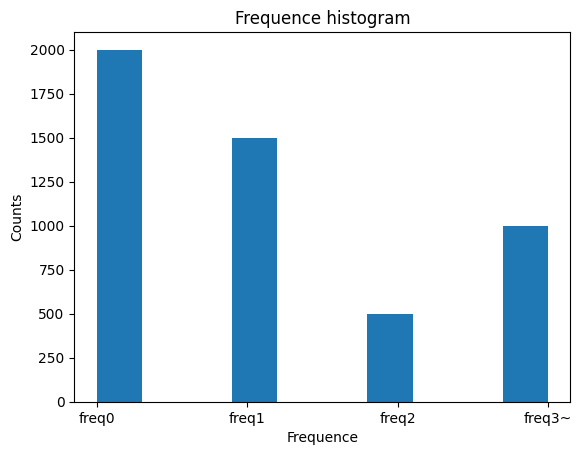

In [12]:
plt.hist(customer_df["freq_cat"].sort_values(ascending=True))
plt.xlabel("Frequence")
plt.ylabel("Counts")
plt.title("Frequence histogram")
plt.show()

In [22]:
customer_pivot_df = pd.pivot_table(data=customer_df, values="customer_id", columns="freq_cat", index="age_cat", aggfunc="count")
customer_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200
age~19,200,150,50,100


In [23]:
customer_pivot_df = customer_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
customer_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


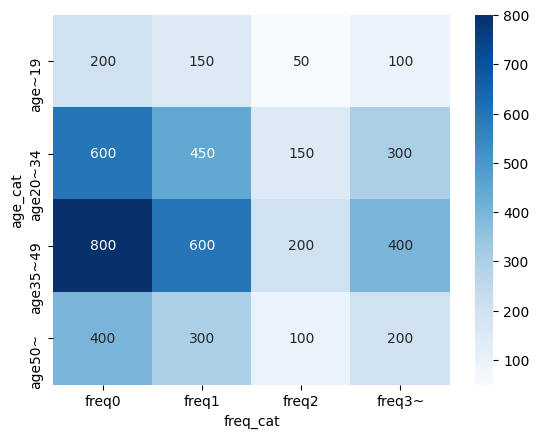

In [25]:
sns.heatmap(customer_pivot_df, annot=True, fmt="d", cmap="Blues");

#### 2-2. 来店確率

In [27]:
visit_probability_df = pd.read_csv("./data/visit_probability.csv")
visit_probability_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


In [28]:
visit_probability_df.shape

(16, 6)

In [29]:
visit_probability_df.describe(include="all")

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
count,16,16,16.000000,16.000000,16.000000,16.000000
unique,4,4,NaN,NaN,NaN,NaN
top,age20~34,freq0,NaN,NaN,NaN,NaN
freq,4,4,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.500000,0.267500,0.366875,0.673750
std,NaN,NaN,4.760952,0.135917,0.158313,0.230387
min,NaN,NaN,1.000000,0.070000,0.120000,0.290000
25%,NaN,NaN,4.750000,0.185000,0.267500,0.527500
50%,NaN,NaN,8.500000,0.280000,0.405000,0.730000
75%,NaN,NaN,12.250000,0.350000,0.460000,0.865000


In [31]:
visit_probability_df.columns

Index(['age_cat', 'freq_cat', 'segment_id', 'prob_dm1', 'prob_dm2',
       'prob_dm3'],
      dtype='object')

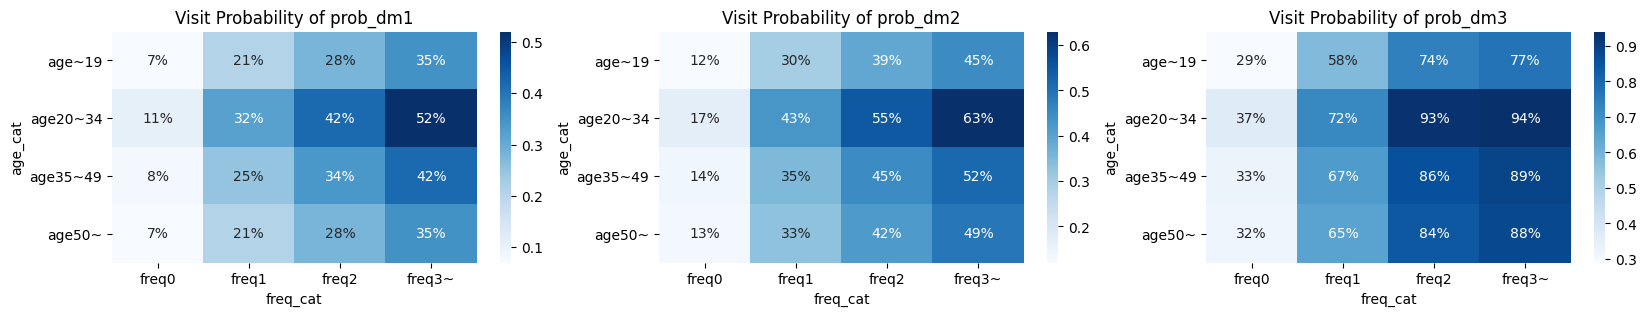

In [59]:
fig,ax = plt.subplots(1,3, figsize=(20,3))
for i, p in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    probability_pivot_df = pd.pivot_table(data=visit_probability_df, values=p, columns="freq_cat", index="age_cat")
    probability_pivot_df = probability_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(probability_pivot_df, annot=True, fmt=".0%", cmap="Blues", ax=ax[i])
    ax[i].set_title(f"Visit Probability of {p}")